# Early Fusion Transformer Model - CMU-MOSEI Dataset

In this notebook, we implement the Early Fusion Transformer Model, and test it on CMU-MOSEI dataset.

## Importing Libraries

In [1]:
import os
import sys
import torch

import numpy as np
import matplotlib.pyplot as plt

sys.path.append(os.getcwd())
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))

## Importing Helper Functions

In [2]:
from helpers.data.get_data import get_dataloader
from helpers.unimodals.common_models import Transformer, MLP, Sequential, Identity
from helpers.training.supervised_learning import train, test
from helpers.fusions.common_fusions import ConcatEarly
from helpers.utils.common_utils import get_default_device, save_results

## Loading the Dataset

In [3]:
traindata, validdata, testdata = get_dataloader(
    '/scratch/rrm9598/data/mosei_senti_data.pkl', robust_test=False)

In [4]:
device = get_default_device()
print(device)

cuda


## Model Architecture

In [5]:
encoders = [Identity().to(device), Identity().to(device), Identity().to(device)]
head = Sequential(Transformer(409, 300).to(device), MLP(300, 128, 1)).to(device)

/home/rrm9598/.local/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [6]:
fusion = ConcatEarly().to(device)

## Training

In [7]:
FILE_NAME = 'mosei_eft_r0'

In [8]:
train_losses, valid_losses = train(
    encoders, fusion, head, traindata, validdata, 100, task="regression", optimtype=torch.optim.AdamW,
    is_packed=True, early_stop=True, lr=1e-4, 
    save=f'/scratch/rrm9598/Multimodal-Sentiment-Analysis/models/{FILE_NAME}.pt', weight_decay=0.01, objective=torch.nn.L1Loss()
)

Epoch [1/100]
Train Loss: 0.8442
Valid Loss: 0.7659
Saving Best

Epoch [2/100]
Train Loss: 0.8167
Valid Loss: 0.7383
Saving Best

Epoch [3/100]
Train Loss: 0.7962
Valid Loss: 0.7586

Epoch [4/100]
Train Loss: 0.7798
Valid Loss: 0.7185
Saving Best

Epoch [5/100]
Train Loss: 0.7695
Valid Loss: 0.7016
Saving Best

Epoch [6/100]
Train Loss: 0.7390
Valid Loss: 0.6895
Saving Best

Epoch [7/100]
Train Loss: 0.7248
Valid Loss: 0.6825
Saving Best

Epoch [8/100]
Train Loss: 0.7138
Valid Loss: 0.6781
Saving Best

Epoch [9/100]
Train Loss: 0.7167
Valid Loss: 0.6907

Epoch [10/100]
Train Loss: 0.7021
Valid Loss: 0.6697
Saving Best

Epoch [11/100]
Train Loss: 0.6905
Valid Loss: 0.6423
Saving Best

Epoch [12/100]
Train Loss: 0.6838
Valid Loss: 0.6546

Epoch [13/100]
Train Loss: 0.6736
Valid Loss: 0.6520

Epoch [14/100]
Train Loss: 0.6667
Valid Loss: 0.6323
Saving Best

Epoch [15/100]
Train Loss: 0.6554
Valid Loss: 0.6405

Epoch [16/100]
Train Loss: 0.6541
Valid Loss: 0.6675

Epoch [17/100]
Train Loss

Text(0.5, 1.0, 'Loss vs. No. of epochs')

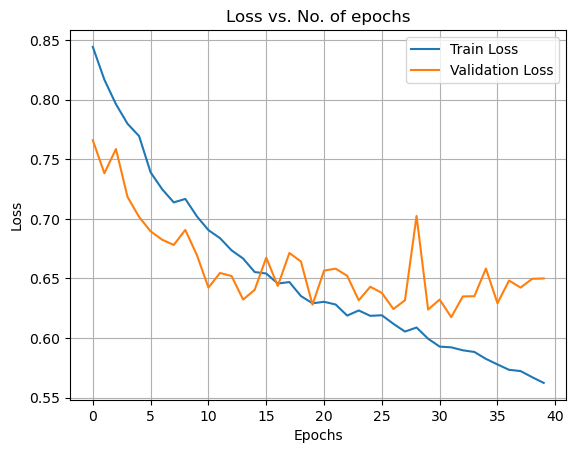

In [9]:
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Loss vs. No. of epochs')

In [10]:
save_results(train_losses, valid_losses, f'/scratch/rrm9598/Multimodal-Sentiment-Analysis/results/{FILE_NAME}.pkl')

## Testing

In [12]:
model = torch.load(f'/scratch/rrm9598/Multimodal-Sentiment-Analysis/models/{FILE_NAME}.pt').to(device)

test(model, testdata, 'affect', is_packed=True,
     criterion=torch.nn.L1Loss(), task="posneg-classification", no_robust=True)

Recall: 79.5304% | Total Accuracy: 69.0933%
Inference Time: 1s579ms
Inference Params: 8129097
